# WGAN

In [1]:
from tensorflow.keras.datasets import mnist
(train_X, _), (test_X, _) = mnist.load_data()

print(train_X.shape, test_X.shape)

(60000, 28, 28) (10000, 28, 28)


In [2]:
import numpy as np

train_X = (train_X.astype(np.float32) - 127.5) / 127.5
test_X = (test_X.astype(np.float32) - 127.5) / 127.5

train_X = np.expand_dims(train_X, axis=3)
test_X = np.expand_dims(test_X, axis=3)

print(train_X.shape, test_X.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [3]:
# Wasserstein Loss
from tensorflow.keras import backend as K

def Wasserstein_loss(y_true, y_pred):

    return K.mean(y_true * y_pred)
    

In [6]:
#######################################################################################

from tensorflow.config.experimental import list_physical_devices, set_memory_growth
gpus = list_physical_devices('GPU')
display(gpus)
if gpus:
  try:
    set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
#######################################################################################

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
#critic
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Flatten, Input, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session

clear_session()

# YOUR PARAMTERS
#######################################################################################

lr = 0.00005  # learning rate
rr = 1e-5  #regularizer rate

epoch = 30
opt = RMSprop(learning_rate=lr)
metrics = [AUC()]

#######################################################################################

def create_critic(input_dim):
    model = Sequential(name="critic")
    
    # MODEL
    #######################################################################################
    
    model.add(Input(input_dim))
    model.add(Conv2D(kernel_size=3, filters=32, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    model.add(Conv2D(kernel_size=3, filters=64, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    model.add(Conv2D(kernel_size=3, filters=128, strides=2, padding="same"))
    model.add(BatchNormalization())    
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(1))

    #######################################################################################
    
    model.summary()
    
    return model

critic = create_critic(train_X.shape[1:])

critic.compile(loss=Wasserstein_loss, optimizer=opt)
critic.trainable = False

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0    

In [8]:
#generator
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Activation, UpSampling2D

z_dim = 100

# YOUR PARAMTERS
#######################################################################################


#######################################################################################

def create_generator(z_dim):
    model = Sequential(name="generator")
    # MODEL
    #######################################################################################

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))

    #######################################################################################
    
    model.summary()

    return model

generator = create_generator(z_dim)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0 

In [9]:
#assemble

model = Sequential(name="WGAN")
model.add(generator)
model.add(critic)
model.compile(loss=Wasserstein_loss, optimizer=opt)
model.summary()

Model: "WGAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         1028673   
_________________________________________________________________
critic (Sequential)          (None, 1)                 95617     
Total params: 1,124,290
Trainable params: 1,028,289
Non-trainable params: 96,001
_________________________________________________________________


In [10]:
#sample img
import matplotlib.pyplot as plt

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, : ,0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [11]:
#train
import numpy as np
d_loss_history = []
g_loss_history = []
def train(iterations, batch_size, sample_interval):
    print("start!!")
    
    real = np.ones((batch_size, 1), dtype=np.float32)
    fake = - real

    for iteration in range(iterations):
        idx = np.random.randint(0, train_X.shape[0], batch_size)
        imgs = train_X[idx]
        for _ in range(5):
            z = np.random.normal(0, 1, (batch_size, 100))
            
            gen_imgs = generator.predict(z)
            
            d_loss_real = critic.train_on_batch(imgs, real)
            d_loss_fake = critic.train_on_batch(gen_imgs, fake)
            d_loss = .5 * np.add(d_loss_real, d_loss_fake)
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = model.train_on_batch(z, real) # train generator GAN.train_on_batch()
        
        if (iteration + 1) % sample_interval == 0:
            print("["+str(iteration+1)+":", "d_loss: ", d_loss, ",", "g_loss: ", str(g_loss)+"]")
            sample_images(generator)

start!!
[2500: d_loss:  2.3771066480549052e-05 , g_loss:  -8.198957948479801e-05]


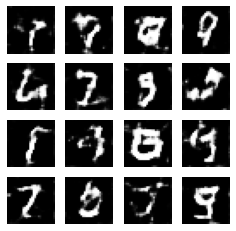

[5000: d_loss:  2.504531221347861e-05 , g_loss:  -7.377612928394228e-05]


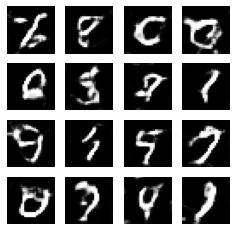

[7500: d_loss:  2.6164001610595733e-05 , g_loss:  -7.636064401594922e-05]


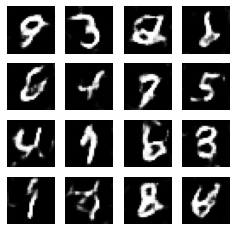

[10000: d_loss:  2.0439129002625123e-05 , g_loss:  -6.64947583572939e-05]


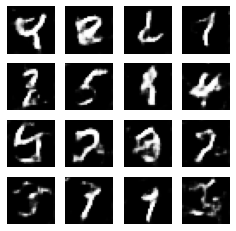

[12500: d_loss:  2.5903424102580175e-05 , g_loss:  -7.245576125569642e-05]


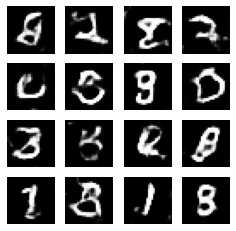

[15000: d_loss:  2.4311728338943794e-05 , g_loss:  -6.800810660934076e-05]


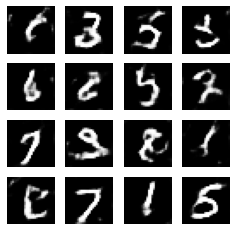

[17500: d_loss:  1.801530015654862e-05 , g_loss:  -7.428655226249248e-05]


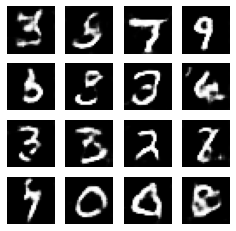

[20000: d_loss:  2.3333024728344753e-05 , g_loss:  -5.449224408948794e-05]


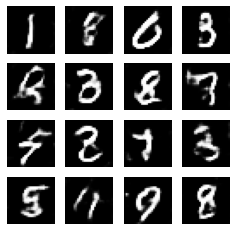

[22500: d_loss:  2.4931385269155726e-05 , g_loss:  -7.660503615625203e-05]


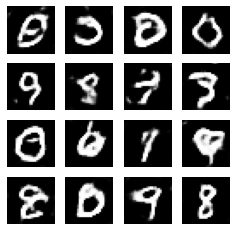

[25000: d_loss:  2.1776777430204675e-05 , g_loss:  -5.644224438583478e-05]


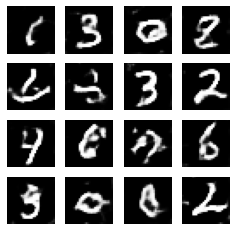

[27500: d_loss:  2.9421767976600677e-05 , g_loss:  -7.7225333370734e-05]


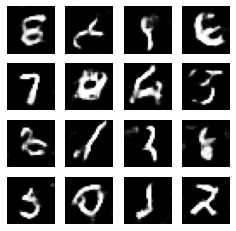

[30000: d_loss:  2.47838361246977e-05 , g_loss:  -5.56922605028376e-05]


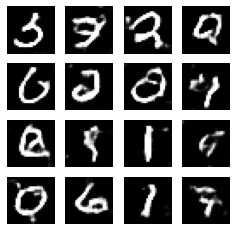

[32500: d_loss:  2.5765897589735687e-05 , g_loss:  -6.558878521900624e-05]


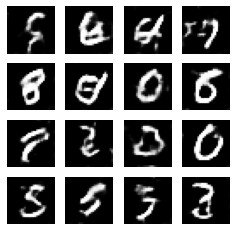

[35000: d_loss:  2.7000914997188374e-05 , g_loss:  -5.99317645537667e-05]


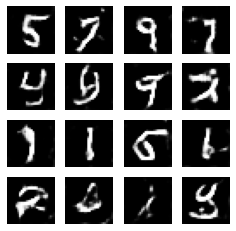

In [ ]:
iterations = 100000
batch_size = 128
sample_iterval = 2500

train(iterations, batch_size, sample_iterval)